## Table of Contents
* [Goals](#goals)
* [Data](#data)
    * [Loading Data](#section1_1)
    * [Data Information](#section1_2)
* [Data Cleaning](#cleaning)
    * [Categorical Data](#section2_1)
    * [Qauntitative Data](#section2_2)
* [Exploratory Data Analysis](#EDA)

### Goals <a class="anchor" id="Goals"></a>
This notebook contains data scraped from a used truck sales websites. The goal of this is project is to do the following:
* Retrieve our data from webscrapes "wild data"
* Clean the data so it is ready for analysis
* Develop some questions for analysis
* Analyze variables within the data to gain patterns and insights on these questions
* Store data in a database
* Create a dashboard presentation using Tableau

### Data <a class="anchor" id="Data"></a>
The data for this project was gathered using Web Scraper; a free Edge plug-in, from [equiptment experts](https://www.equipmentexperts.com/). This website shows listings for Class A heavy duty equiptment.

#### Loading the Data <a class="anchor" id="section1_1"></a>
We will import the librarys we plan on using and view the first 5 lines of the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
data = pd.read_csv('equiptment_experts_raw_data.csv')
data.head()

,mileage,dealer,location,price,make,website
0,"461,060 mi",Doggett Freightliner,"Pharr, TX","$34,900",2015 Volvo VNL,https://www.equipmentexperts.com/trucking/heav...
1,"391,294 mi",Arrow Truck Sales,"French Camp, CA","$106,950",2020 KENWORTH T680,https://www.equipmentexperts.com/trucking/heav...
2,"476,567 mi",Bonander Truck & Trailer,"Turlock, CA","$88,500",2016 Freightliner Cascadia,https://www.equipmentexperts.com/trucking/heav...
3,"139,319 mi",Dobbs Peterbilt,"North Little Rock, AR","$171,950",2022 PETERBILT 579,https://www.equipmentexperts.com/trucking/heav...
4,"674,852 mi",Truck and Van Outlet,"Miami, FL","$49,995",2012 Kenworth T700,https://www.equipmentexperts.com/trucking/heav...


#### Data Information <a class="anchor" id="section1_2"></a>
some immediate insights are:
* `mileage` is an object and needs to be stripped and converted to a float. There are also some null values and we should investigate values such as "1 mi"
* `location` column can be split to City and State columns
* `price` dtype needs to be converted to a int and although it is not showing any null values there are values like "Call for Price"
* `make` column needs to be split into "year", "make", "model" and formatted
* `website` dtype needs to be html
* `year` needs to be an ordered category


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mileage   8485 non-null   object
 1   dealer    8857 non-null   object
 2   location  8857 non-null   object
 3   price     8857 non-null   object
 4   make      8857 non-null   object
 5   website   8857 non-null   object
dtypes: object(6)
memory usage: 415.3+ KB


In [4]:
data.isnull().sum()

mileage     372
dealer        0
location      0
price         0
make          0
website       0
dtype: int64

In [5]:
data.describe()

,mileage,dealer,location,price,make,website
count,8485,8857,8857,8857,8857,8857
unique,8290,76,498,1694,1299,8857
top,1 mi,Penske Used Trucks,"Covington, TN",Call For Price,2016 FREIGHTLINER X12564ST,https://www.equipmentexperts.com/trucking/heav...
freq,10,2237,804,355,563,1


### Data Cleaning <a class="anchor" id="cleaning"></a>

#### Categorical Data Cleaning <a class="anchor" id="section2_1"></a>

We will start with seperating all our categorical data into their desired columns
* create `year`, `make`, `model` columns
    * 1 issue was with the format 'Navistar'(Parent Company of International) on International trucks that had different format than the rest of the trucks. I first had to remove this in order properly split the columns
* create `city`, `state` columns
* check our makes and drop any makes in the data that are not Class A vehicles

In [6]:
# removing 'Navistar' from makes so that we can split correctly
data['make'] = data['make'].str.title()
data['make'] = data['make'].str.replace('Navistar', '')

# creating new columns and adding the data to them from the make column
data['year'] = data['make'].apply(lambda x: str(x).split()[0])
data['model'] = data['make'].apply(lambda x: ''.join(str(x).split()[2:]))
data['make'] = data['make'].apply(lambda x: str(x).split()[1])

# creating city and state columns and removing location column
data['city'] = data['location'].apply(lambda x: str(x).split(',')[0])
data['state'] = data['location'].apply(lambda x: str(x).split(',')[1])
data.drop(columns='location', axis=1, inplace=True)

#changing website datatype
def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'
data.style.format({'websiite': make_clickable})


data.head()

,mileage,dealer,price,make,website,year,model,city,state
0,"461,060 mi",Doggett Freightliner,"$34,900",Volvo,https://www.equipmentexperts.com/trucking/heav...,2015,Vnl,Pharr,TX
1,"391,294 mi",Arrow Truck Sales,"$106,950",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2020,T680,French Camp,CA
2,"476,567 mi",Bonander Truck & Trailer,"$88,500",Freightliner,https://www.equipmentexperts.com/trucking/heav...,2016,Cascadia,Turlock,CA
3,"139,319 mi",Dobbs Peterbilt,"$171,950",Peterbilt,https://www.equipmentexperts.com/trucking/heav...,2022,579,North Little Rock,AR
4,"674,852 mi",Truck and Van Outlet,"$49,995",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2012,T700,Miami,FL


In [7]:
print(data.make.unique())

['Volvo' 'Kenworth' 'Freightliner' 'Peterbilt' 'Mack' 'International'
 'Western' 'Sterling' 'Ftl' 'Gmc' 'Ford' 'Autocar' 'Cascadia' 'Isuzu'
 '379' 'Caterpillar' 'Kaiser' 'Ccc' 'Chevrolet' '567' 'Oshkosh' 'Bmy']


a couple of issues arrise:
* not all makes are stricly class A
* some models ended up in our makes '567', 'Cascadia'
* 'Ftl' is a 'Freightliner' and 'Western' is a 'Western Star'

In [8]:
suspect_models = ['567', 'Ftl', 'Cascadia', '379', 'Western']
for model in suspect_models:
    print(data[data['make'] == model])

# 567: missing year, information not provided by website
# Ftl: incorrect model, information not provided by website
# Cascadia: missing year, information not provided by website
# Western: can be fixed, only 'make' with 2 words, Star is part of model

        mileage                dealer     price make   
6927  62,802 mi  Dobbs Peterbilt - WA  $279,999  567  \

                                                website       year model   
6927  https://www.equipmentexperts.com/trucking/heav...  Peterbilt        \

        city state  
6927  Sumner    WA  
        mileage                 dealer    price make   
530  146,647 mi  Southport Truck Group  $39,900  Ftl  \

                                               website  year    model   
530  https://www.equipmentexperts.com/trucking/heav...  2012  Ca125Dc  \

           city state  
530  Fort Myers    FL  
         mileage           dealer    price      make   
2027  731,058 mi  TSI Truck Sales  $73,900  Cascadia  \
2510  725,534 mi  TSI Truck Sales  $74,900  Cascadia   
2518  744,345 mi  TSI Truck Sales  $62,900  Cascadia   
2521  716,361 mi  TSI Truck Sales  $74,900  Cascadia   

                                                website          year model   
2027  https://www.equipm

In [9]:
# removing Star from model and correcting all Western Star makes
data['model'] = data['model'].apply(lambda x: str(x).strip('Star'))
data['make'] = data['make'].apply(lambda x: x + ' Star' if x == 'Western' else x)

#removing all rows that are not a class A vehicle
class_a = ['Volvo', 'Kenworth', 'Freightliner', 'Peterbilt', 'Mack', 'International', 'Western Star']
data = data[data['make'].isin(class_a)]
print(data['make'].unique())


['Volvo' 'Kenworth' 'Freightliner' 'Peterbilt' 'Mack' 'International'
 'Western Star']


We will now work to make the `year` column categorical
* one of the values for `year` is incorrect we will remove that

In [10]:
# getting list of years for categories
years = data['year'].unique()
years

array(['2015', '2020', '2016', '2022', '2012', '2019', '2000', '2017',
       '2018', '2001', '2014', '2008', '2010', '2004', '2005', '2009',
       '2021', '1996', '2013', '2007', '2011', '2006', '1997', '1998',
       '1987', '2023', '2003', '1989', '2002', '2024', '1988', '1993',
       '1995', '1991', '1986', '1994', '1999', '1990', '1985', '1966',
       '1963', '1992', '1982', '1972', '1980', '1979', '1984', '201'],
      dtype=object)

In [11]:
# removing all instances of invalid year using regular expression for 4 digits
data = data[data['year'].apply(lambda x: bool(re.match(r'^\d{4}$', x)))]

# changing year column to an ordered category
data['year'] = pd.Categorical(data['year'], categories=data['year'].unique(), ordered=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8719 entries, 0 to 8856
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   mileage  8379 non-null   object  
 1   dealer   8719 non-null   object  
 2   price    8719 non-null   object  
 3   make     8719 non-null   object  
 4   website  8719 non-null   object  
 5   year     8719 non-null   category
 6   model    8719 non-null   object  
 7   city     8719 non-null   object  
 8   state    8719 non-null   object  
dtypes: category(1), object(8)
memory usage: 623.0+ KB


#### Qantitiative Data Cleaning <a class="anchor" id="section2_2"></a>
The `mileage` and `price` column are going to be our main columns for analysis so we need to ensure these are the cleanest we will start by:
* converting all psuedo NaN values to an acutal Nan and then removing them from our dataset
* removing commas and strings from `mileage` and converting them to integers
* removing $ and commas from `price` and converting them to floats

Both columns are then looked at using a boxplot for outliers since we have found some we will explore there merit

In [12]:
# replacing values 'nan' and 'Call For Price' with actual Nan values
data['price'] = data['price'].replace('Call For Price', np.NaN)
data['mileage'] = data['mileage'].replace('nan', np.NaN)

#drop all NaN values from mileage and price
data = data.dropna(how = 'any').reset_index(drop=True)

#spliting strings, removing commas, converting to int64 - (some values were too big we need to investigate)
data['mileage'] = data['mileage'].apply(lambda x: str(x).split(' ')[0].replace(',', '')).astype('int64')
data['price'] = data['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype('float')

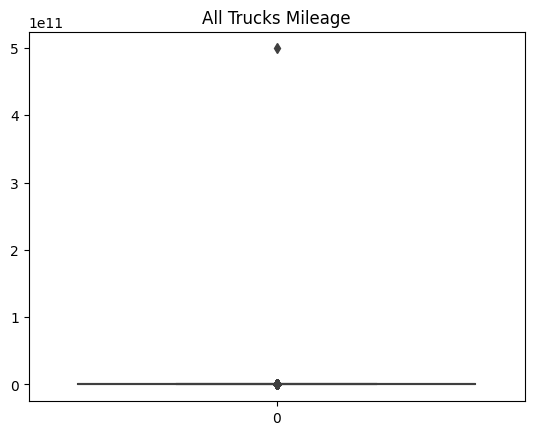

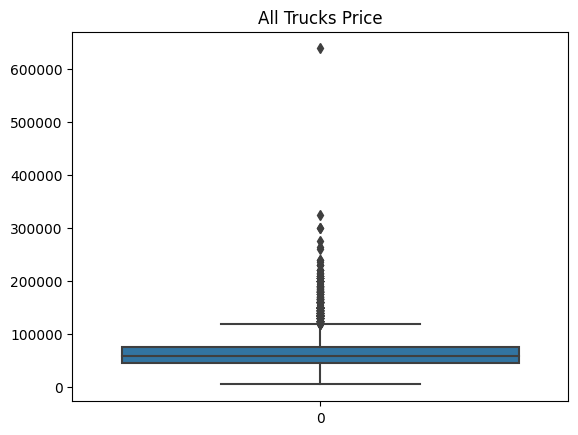

<Figure size 640x480 with 0 Axes>

In [13]:
#plottig boxplot for outlier information
sns.boxplot(data['mileage'])
plt.title('All Trucks Mileage')
plt.show()
plt.clf()
sns.boxplot(data['price'])
plt.title('All Trucks Price')
plt.show()
plt.clf()

There is a significant outlier showing 500 trillion miles- "and on the first day God created a 2018 Volvo VNL" sounds legit right! lets go ahead and remove that from our data

There is also a high amount for a used truck, after exploring this outlier on the below scatter plot compared to vehicles like it, I have determined they must have added an extra 0 when publishing it. The truck is no longer on the website so I cannot verify for sure if maybe this was a heavy haul or possibly an oil field rig either way we are removing it from our dataset

In [14]:
#exploring the outlier for high mileage
high_mileage_truck = data[data['mileage'] > 3000000]
high_mileage_truck

,mileage,dealer,price,make,website,year,model,city,state
854,499113501094,Tri-State Truck Center Inc,85995.0,Volvo,https://www.equipmentexperts.com/trucking/heav...,2018,Vnl64T860,Memphis,TN


In [15]:
#exploring the outlier for high price
high_price_outlier = data[data['price'] > 500000]
data_like_outlier = data[(data['year'] == '2018') & (data['make'] == 'Freightliner') & (data['mileage'].between(550000, 600000))]
high_price_outlier

,mileage,dealer,price,make,website,year,model,city,state
3724,588319,M&K Truck Centers,638400.0,Freightliner,https://www.equipmentexperts.com/trucking/heav...,2018,Cascadia126,Indianapolis,IN


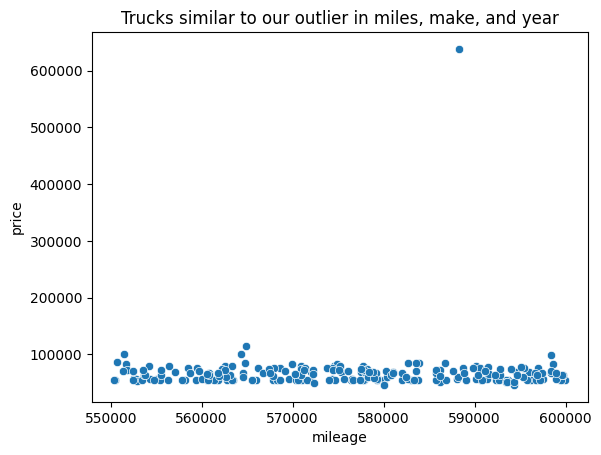

<Figure size 640x480 with 0 Axes>

In [16]:
sns.scatterplot(data_like_outlier, x='mileage', y='price')
plt.title('Trucks similar to our outlier in miles, make, and year')
plt.show()
plt.clf()

Removing outliers from dataset
We will also remove any truck with mileage less than 10000 miles as we are exploring used trucks not new trucks this will also clean our data from really high prices of newer trucks

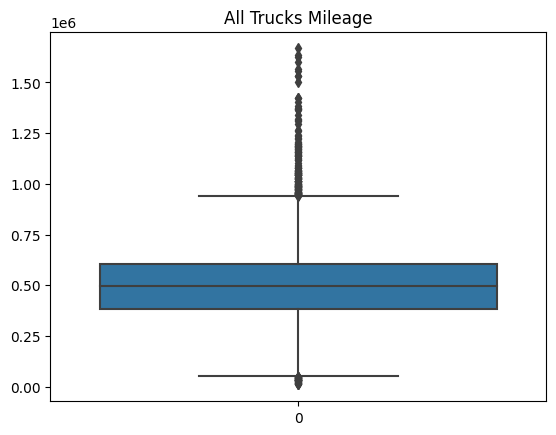

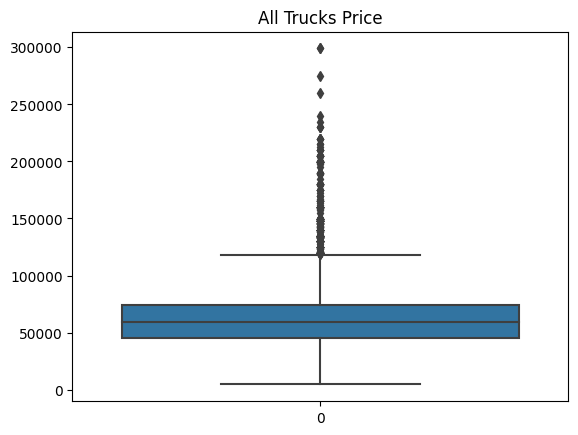

<Figure size 640x480 with 0 Axes>

In [17]:
data = data[data['price'] < 600000]
data = data[data['mileage'].between(10000, 2000000)]

sns.boxplot(data['mileage'])
plt.title('All Trucks Mileage')
plt.show()
plt.clf()
sns.boxplot(data['price'])
plt.title('All Trucks Price')
plt.show()
plt.clf()


In [18]:
data.describe()

,mileage,price
count,8.109000e+03,8109.000000
mean,4.951429e+05,62187.581329
std,1.885170e+05,27927.353302
min,1.105000e+04,4500.000000
25%,3.841300e+05,45500.000000
50%,4.958980e+05,58883.000000
75%,6.061270e+05,74500.000000
max,1.667000e+06,299000.000000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8109 entries, 0 to 8129
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   mileage  8109 non-null   int64   
 1   dealer   8109 non-null   object  
 2   price    8109 non-null   float64 
 3   make     8109 non-null   object  
 4   website  8109 non-null   object  
 5   year     8109 non-null   category
 6   model    8109 non-null   object  
 7   city     8109 non-null   object  
 8   state    8109 non-null   object  
dtypes: category(1), float64(1), int64(1), object(6)
memory usage: 837.5+ KB


In [20]:
# re-arranging columns
data = data[['year', 'make', 'model', 'price', 'mileage', 'dealer', 'city', 'state', 'website']]
data.head()

,year,make,model,price,mileage,dealer,city,state,website
0,2015,Volvo,Vnl,34900.0,461060,Doggett Freightliner,Pharr,TX,https://www.equipmentexperts.com/trucking/heav...
1,2020,Kenworth,T680,106950.0,391294,Arrow Truck Sales,French Camp,CA,https://www.equipmentexperts.com/trucking/heav...
2,2016,Freightliner,Cascadi,88500.0,476567,Bonander Truck & Trailer,Turlock,CA,https://www.equipmentexperts.com/trucking/heav...
3,2022,Peterbilt,579,171950.0,139319,Dobbs Peterbilt,North Little Rock,AR,https://www.equipmentexperts.com/trucking/heav...
4,2012,Kenworth,T700,49995.0,674852,Truck and Van Outlet,Miami,FL,https://www.equipmentexperts.com/trucking/heav...


exporting dataframe to SQLlite Database
 * should only be run 1 time - commented out during running

In [21]:
#from sqlalchemy import create_engine
#engine = create_engine(r'sqlite:///C:\Users\devan\OneDrive\Desktop\Portfolio\truck-sales-project\Truck-Sales-DB')
#data.to_sql('truck-sales', con=engine, index=False)

exporting dataframe to csv for Tableau

In [22]:
#file_path = "truck-sales-data-cleaned.csv"
#data.to_csv(file_path, index=False)

### Exploratory Data Analysis <a class="anchor" id="EDA"></a>

After some data cleaning and tidying, the DataFrame is ready for EDA. The following independent variables will be focused on in the analysis:
* `price`
* `mileage`

The goal will be to see how these independent variables associate with the other variables:
* `year`
* `make`
* `state`
* `dealer`

The hope is that through summary statistics and visualizations the following questions can be answered:
* What truck make retains value after so many years?
* What the average price is for each make/year?
* What state and dealer offer the best bang for your buck?

Along the way, these question may be refined and more questions may pop up.

In [23]:
data.head()

,year,make,model,price,mileage,dealer,city,state,website
0,2015,Volvo,Vnl,34900.0,461060,Doggett Freightliner,Pharr,TX,https://www.equipmentexperts.com/trucking/heav...
1,2020,Kenworth,T680,106950.0,391294,Arrow Truck Sales,French Camp,CA,https://www.equipmentexperts.com/trucking/heav...
2,2016,Freightliner,Cascadi,88500.0,476567,Bonander Truck & Trailer,Turlock,CA,https://www.equipmentexperts.com/trucking/heav...
3,2022,Peterbilt,579,171950.0,139319,Dobbs Peterbilt,North Little Rock,AR,https://www.equipmentexperts.com/trucking/heav...
4,2012,Kenworth,T700,49995.0,674852,Truck and Van Outlet,Miami,FL,https://www.equipmentexperts.com/trucking/heav...


most of the data we have regarding price are outliers we will try and make a predictive model based on the mileage and price of the data we have

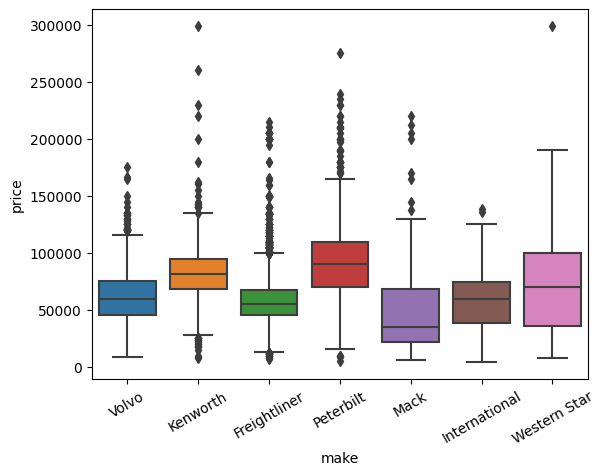

<Figure size 640x480 with 0 Axes>

In [24]:
sns.boxplot(data, x='make', y='price')
plt.xticks(rotation=30)
plt.show()
plt.clf()
    

Here we can see our predictive model is not very good this is likely because our population is skewed right

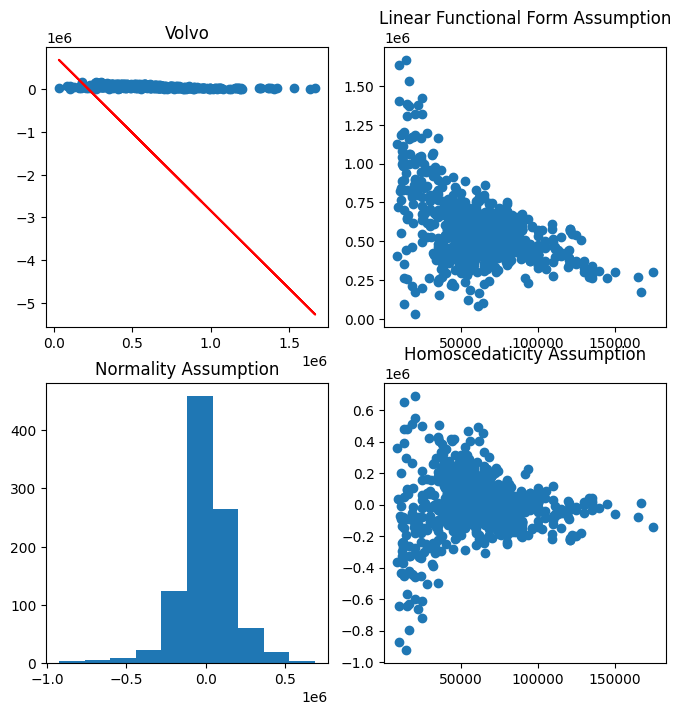

a Volvo with 350000 mi is has an estimated value of : $-479149.67893158447


<Figure size 640x480 with 0 Axes>

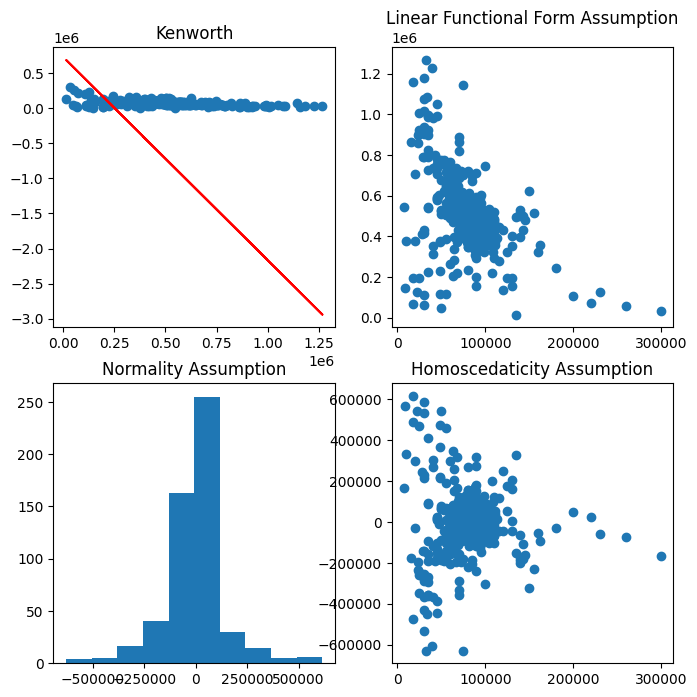

a Kenworth with 350000 mi is has an estimated value of : $-282076.44975037023


<Figure size 640x480 with 0 Axes>

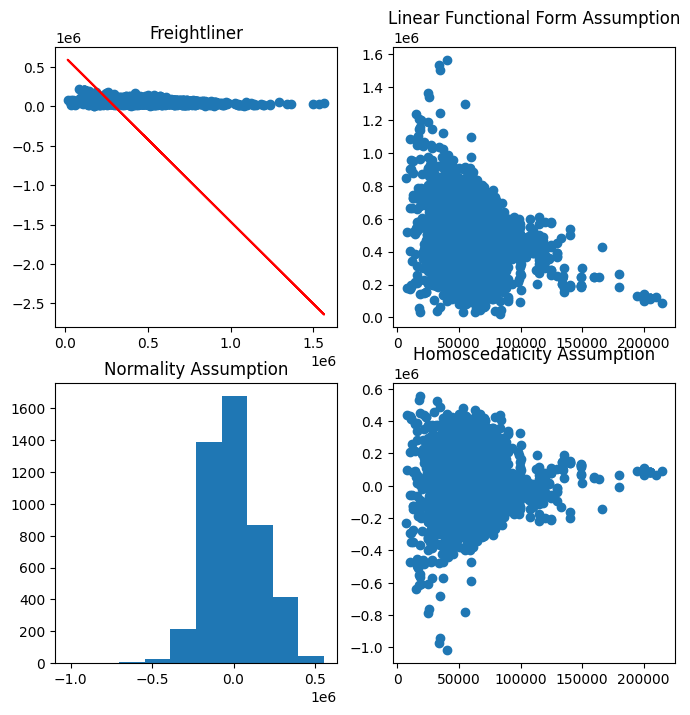

a Freightliner with 350000 mi is has an estimated value of : $-102712.7748523351


<Figure size 640x480 with 0 Axes>

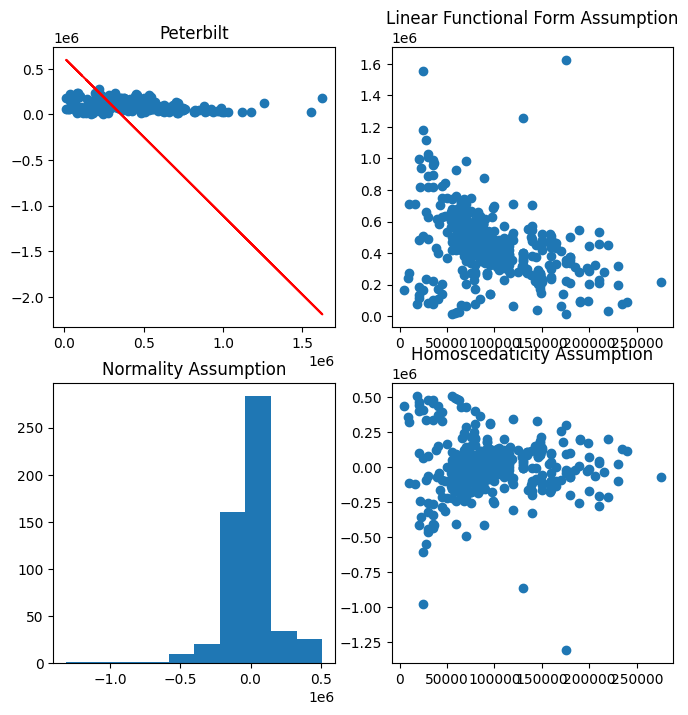

a Peterbilt with 350000 mi is has an estimated value of : $12442.863223170396


<Figure size 640x480 with 0 Axes>

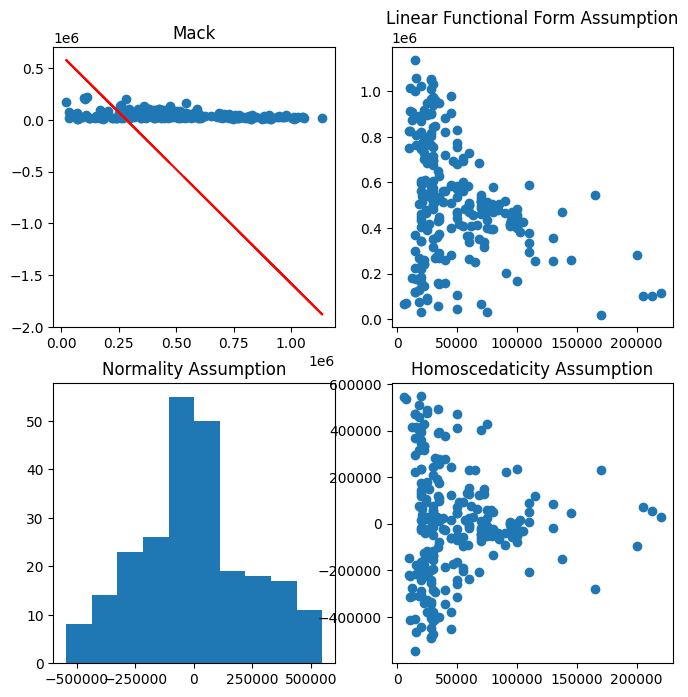

a Mack with 350000 mi is has an estimated value of : $-146667.31269449042


<Figure size 640x480 with 0 Axes>

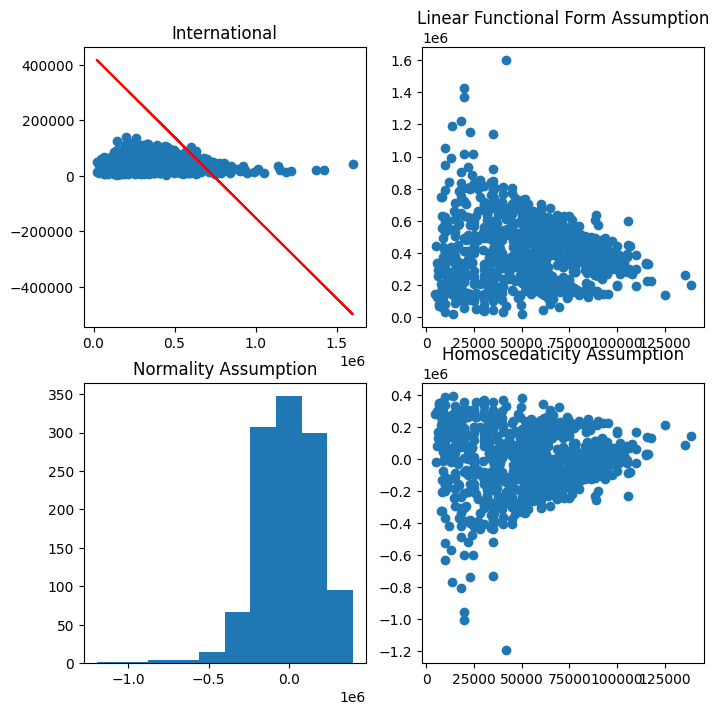

a International with 350000 mi is has an estimated value of : $226631.4462378169


<Figure size 640x480 with 0 Axes>

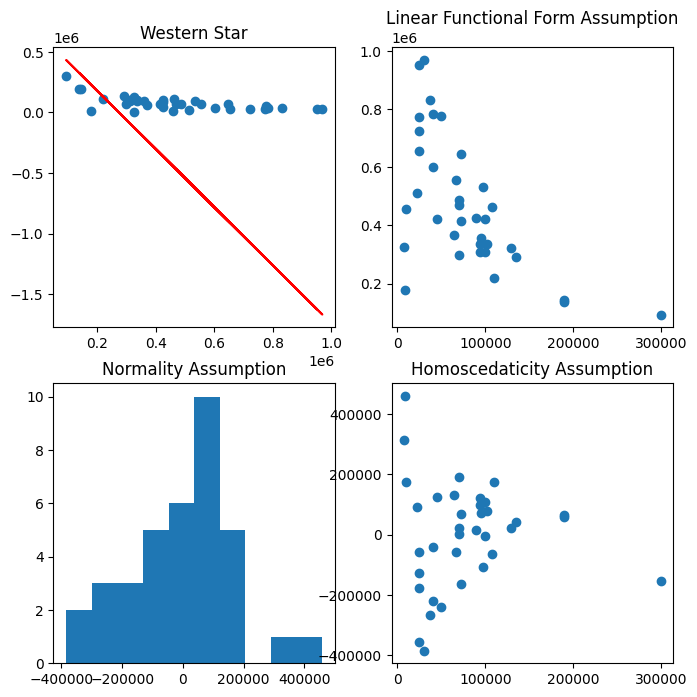

a Western Star with 350000 mi is has an estimated value of : $-182802.54745906545


<Figure size 640x480 with 0 Axes>

In [85]:
import statsmodels.api as sm
all_results = []
def predictive_model_mileage_to_price(df, mileage):
    for i, make in enumerate(df['make'].unique()):
        oem = df[df['make'] == make]
        plt.figure(figsize=(8,8))
        model = sm.OLS.from_formula('mileage ~ price', oem)
        results = model.fit()
        all_results.append(results)

        plt.subplot(2,2,1)
        y = results.params[1]* oem['mileage'] + results.params[0]
        plt.plot(oem['mileage'], y, color='red')
        plt.scatter(oem['mileage'], oem['price'])
        plt.title(make)
        

        fitted_values = results.predict(oem)
        plt.subplot(2,2,2)
        residuals = fitted_values - oem['mileage']
        plt.scatter(oem['price'], oem['mileage'])
        plt.title('Linear Functional Form Assumption')

        plt.subplot(2,2,3)
        plt.hist(residuals)
        plt.title('Normality Assumption')


        plt.subplot(2,2,4)
        plt.scatter(oem['price'], residuals)
        plt.title('Homoscedaticity Assumption')
        plt.show()
        plt.clf()

        info = {'price': mileage}
        prediction = results.predict(info)
        print(f'a {make} with {mileage} mi is has an estimated value of : ${prediction[0]}')



    return all_results

results = predictive_model_mileage_to_price(data, 350000)

all Three Assumptions fail
* Linear function form must have a clear linear relationship
* Normality should be a normally distributed this one is left skewed
* Homoscedacticity should be symmetrically scattered around 0

We will try and perform a sampling distribution to resolve this.

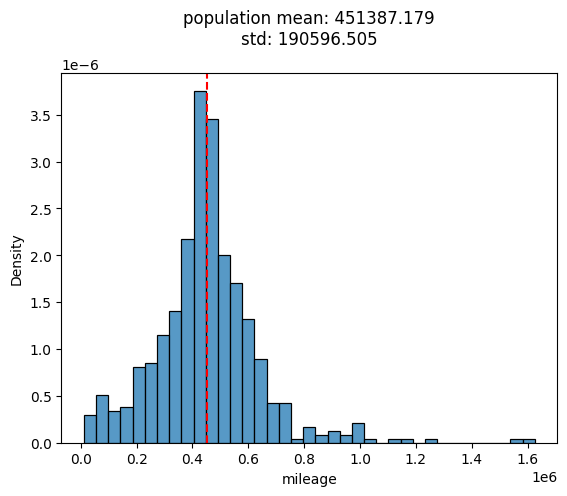

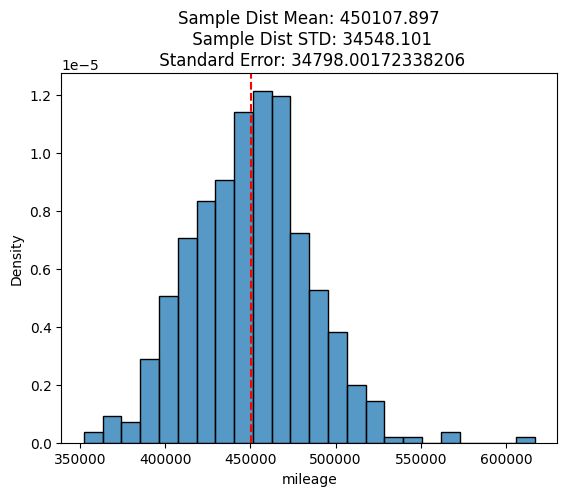

<Figure size 640x480 with 0 Axes>

In [48]:
population = data['mileage'].where(data['make']=='Peterbilt')
population.dropna(inplace=True)
pop_mean = round(np.mean(population),3)
pop_std = round(np.std(population),3)
sns.histplot(population, stat='density')
plt.axvline(pop_mean, color='red', linestyle='dashed')
plt.title(f'population mean: {pop_mean}\nstd: {pop_std}\n')
plt.xlabel('mileage')
plt.show()
plt.clf()

sample_size = 30
sample_means = []

for i in range(500):
    sample = np.random.choice(population, sample_size, replace=False)
    sample_mean = round(np.mean(sample), 3)
    sample_means.append(sample_mean)

mean_sampling_distribution = round(np.mean(sample_means),3)
std_sampling_distribution = round(np.std(sample_means),3)
std_error = pop_std/ (sample_size **0.5)

sns.histplot(sample_means, stat='density')
#plt.axvline(sample_mean, color='red', linestyle='dashed')
plt.title(f'Sample Dist Mean: {mean_sampling_distribution}\n Sample Dist STD: {std_sampling_distribution}\n Standard Error: {std_error}')
plt.xlabel('mileage')
plt.axvline(mean_sampling_distribution, color='red', linestyle='dashed')
plt.show()
plt.clf()

In [90]:
def create_sampling_dist_df(data):
    mileage_list = []
    price_list = []
    make_list = []
    columns = ['mileage', 'price']
    for make in data['make'].unique():
        for column in columns:

            population = data[column].where(data['make']==make)
            population.dropna(inplace=True)
            pop_mean = round(np.mean(population),3)
            pop_std = round(np.std(population),3)
            #sns.histplot(population, stat='density')
            #plt.axvline(pop_mean, color='red', linestyle='dashed')
            #plt.title(f'population mean: {pop_mean}\nstd: {pop_std}\n')
            #plt.xlabel('mileage')
            #plt.show()
            #plt.clf()

            sample_size = 30
            sample_means = []

            for i in range(500):
                sample = np.random.choice(population, sample_size, replace=False)
                sample_mean = round(np.mean(sample), 3)
                sample_means.append(sample_mean)
            if column == 'mileage':
                sample_means.sort()
                for mu in sample_means:
                    mileage_list.append(mu)
            else:
                for mu in sample_means:
                    sample_means.sort(reverse=True)
                    price_list.append(mu)
                for i in range(len(sample_means)):
                    make_list.append(make)            

            #mean_sampling_distribution = round(np.mean(sample_means),3)
            #std_sampling_distribution = round(np.std(sample_means),3)
            #std_error = pop_std/ (sample_size **0.5)

            #sns.histplot(sample_means, stat='density')
            #plt.title(f'Sample Dist Mean: {mean_sampling_distribution}\n Sample Dist STD: {std_sampling_distribution}\n Standard Error: {std_error}')
            #plt.xlabel('mileage')
            #plt.axvline(mean_sampling_distribution, color='red', linestyle='dashed')
            #plt.show()
            #plt.clf()
    combined = list(zip(mileage_list, price_list, make_list))
    return pd.DataFrame(combined, columns=['mileage', 'price', 'make'])

sample_df = create_sampling_dist_df(data)
sample_df.head()



,mileage,price,make
0,482245.600,55914.600,Volvo
1,491858.133,73917.533,Volvo
2,494008.267,73564.867,Volvo
3,497816.667,72491.100,Volvo
4,499120.200,72143.333,Volvo


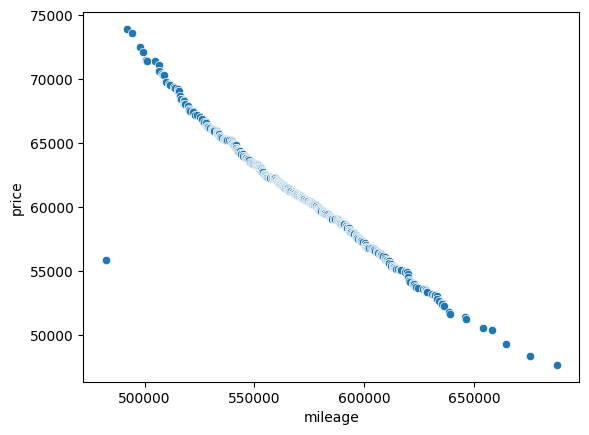

<Figure size 640x480 with 0 Axes>

In [93]:
volvo = sample_df[sample_df['make']=='Volvo']
sns.scatterplot(volvo, x='mileage', y='price')
plt.show()
plt.clf()

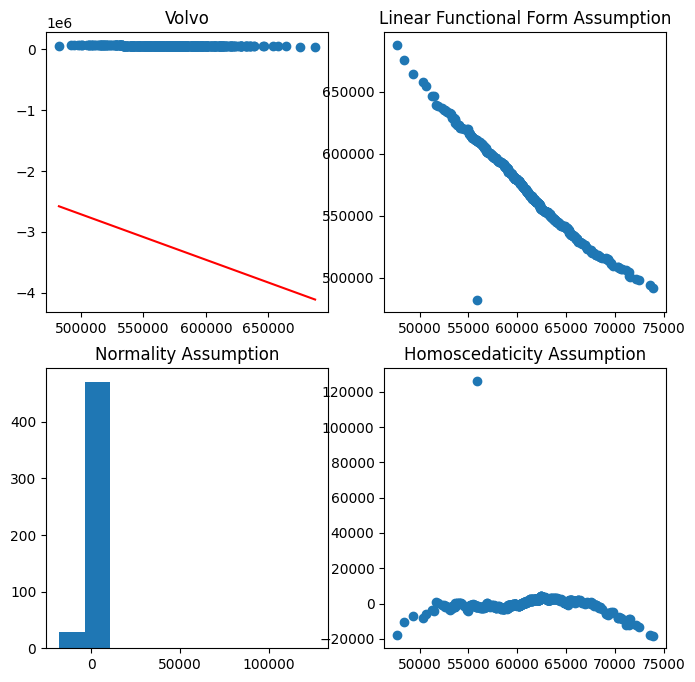

a Volvo with 600000 mi is has an estimated value of : $-3460602.1082275175


<Figure size 640x480 with 0 Axes>

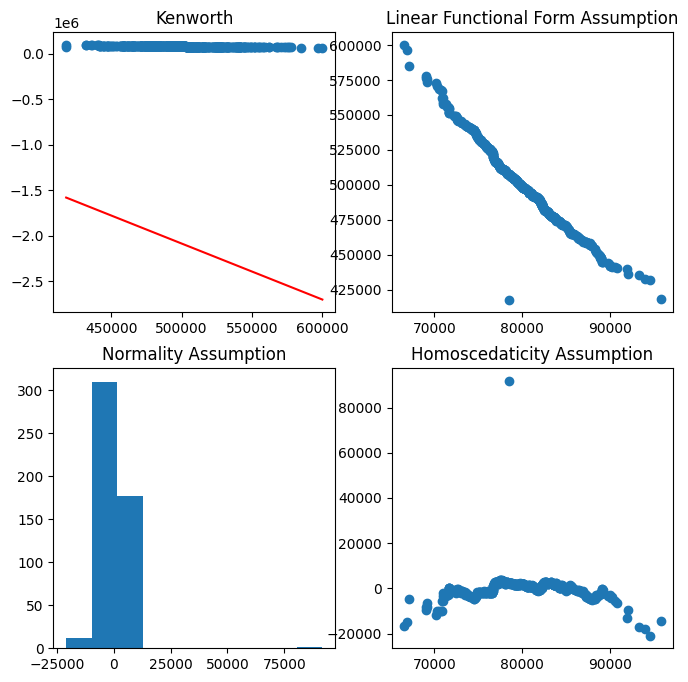

a Kenworth with 600000 mi is has an estimated value of : $-2701711.618647946


<Figure size 640x480 with 0 Axes>

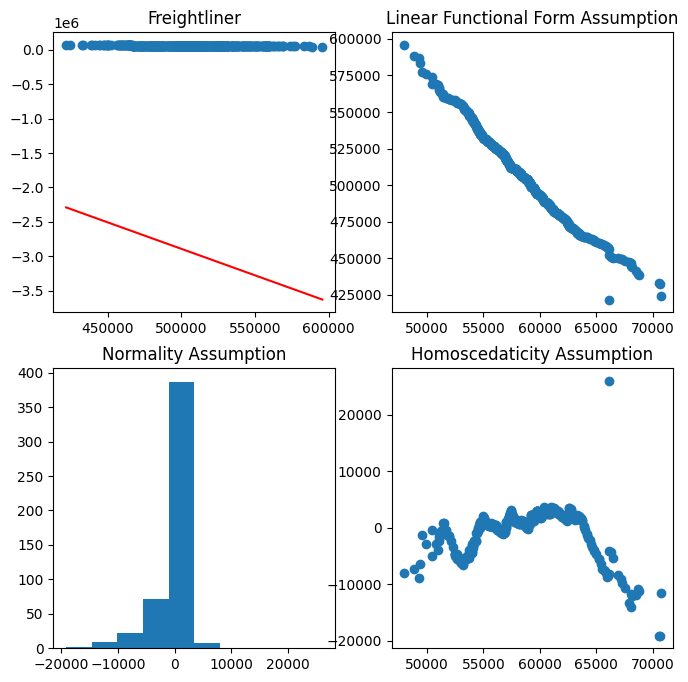

a Freightliner with 600000 mi is has an estimated value of : $-3662581.6783739524


<Figure size 640x480 with 0 Axes>

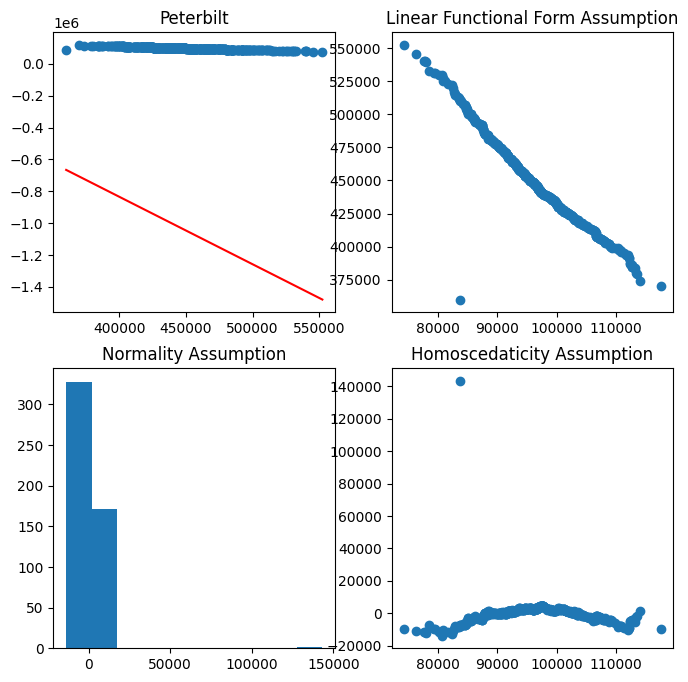

a Peterbilt with 600000 mi is has an estimated value of : $-1680956.705804659


<Figure size 640x480 with 0 Axes>

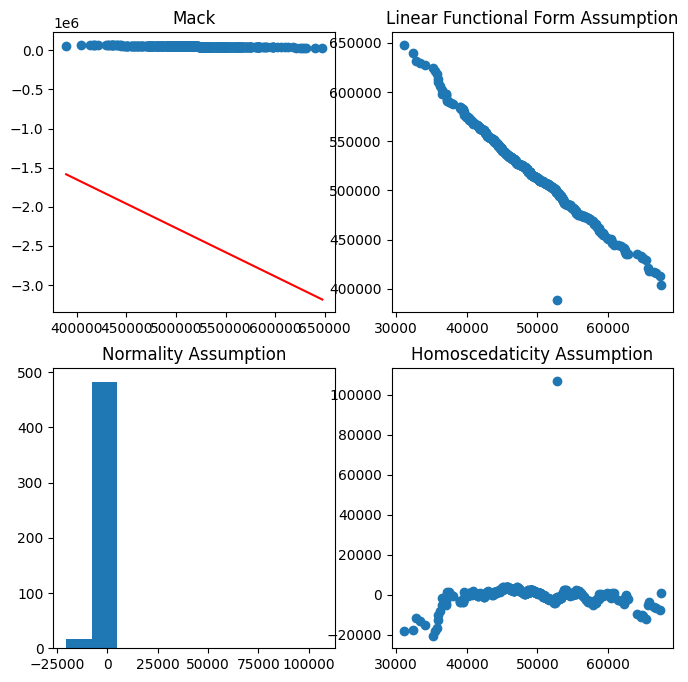

a Mack with 600000 mi is has an estimated value of : $-2890446.195739474


<Figure size 640x480 with 0 Axes>

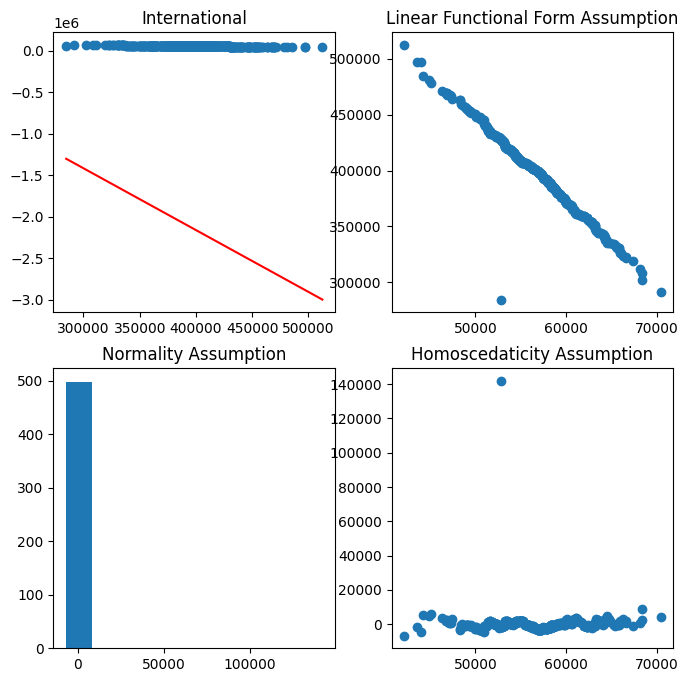

a International with 600000 mi is has an estimated value of : $-3648306.7613649126


<Figure size 640x480 with 0 Axes>

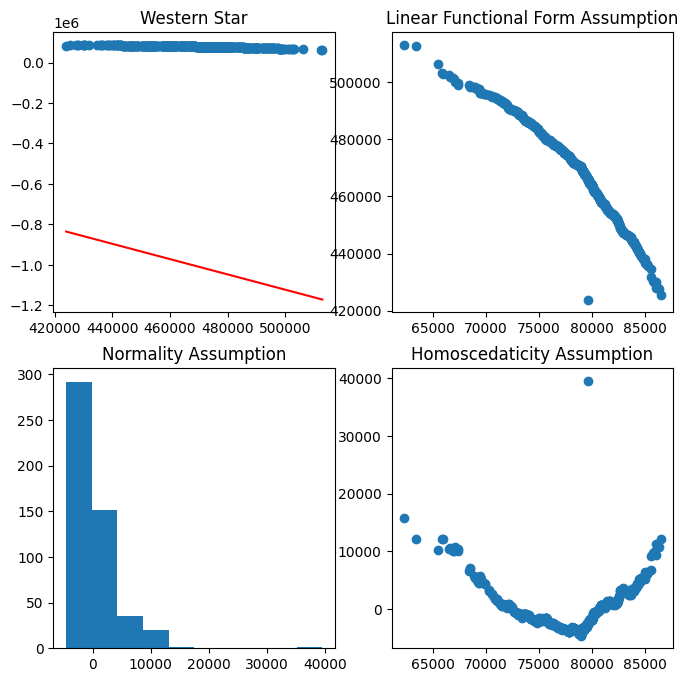

a Western Star with 600000 mi is has an estimated value of : $-1499016.2884778967


<Figure size 640x480 with 0 Axes>

In [91]:
predictive_model_mileage_to_price(sample_df, 600000)